# Gaussian Layer Mask Utilities — Tutorial

This short tutorial demonstrates the helper functions from `utils.layer_mask` used to create multi-scale Gaussian masks from single-channel images. You'll see:

- What each function returns (shapes and intended use),
- A minimal reproducible example using a random tensor,
- How to visualize the generated layers.

Notes: these helpers expect single-channel images (grayscale or masks).

In [10]:
import sys
import os

# Get the absolute path of the 'tutorials' directory
notebook_dir = os.path.abspath('') 

# Get the path to the parent directory (the project root)
project_root = os.path.dirname(notebook_dir)

# Add the project root to the sys.path so we can import utils from the repo
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import matplotlib.pyplot as plt
import inspect

from utils.layer_mask import gaussian_layer_stack_pipeline, plot_layers_any

`gaussian_layer_stack_pipeline` — summary:
- Input: a batch of single-channel images. Typical shapes accepted by the helper in this repo: `(B, H, W)` or `(B, 1, H, W)` (we use `(B, H, W)` in examples).
- Returns: a tuple `(stacked, flat, tiled)` where:
  - `stacked`: (B, n_layers, 32, 32) — small stacked layers intended for visualization (one 32x32 image per layer),
  - `flat`:    (B, n_layers, 1024) — flattened 32x32 per-layer vectors (useful for e.g. linear ops),
  - `tiled`:   (B, n_layers, 1024, 1024) — large tiled masks suitable for elementwise masking in attention maps or other large maps.

`plot_layers_any` — summary:
- Helper to visualize a batch of stacked layers. Pass a `stacked` tensor (or a subset) and it will render each layer as an image grid.

Usage example (below): we create a reproducible random tensor, run the pipeline with `n_layers=8`, print shapes and visualize results.

Stacked shape: torch.Size([2, 8, 32, 32])
Flat shape:    torch.Size([2, 8, 1024])
Tiled shape:   torch.Size([2, 8, 1024, 1024])

Visualizing image 1/2


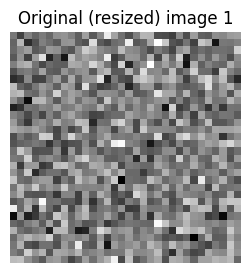

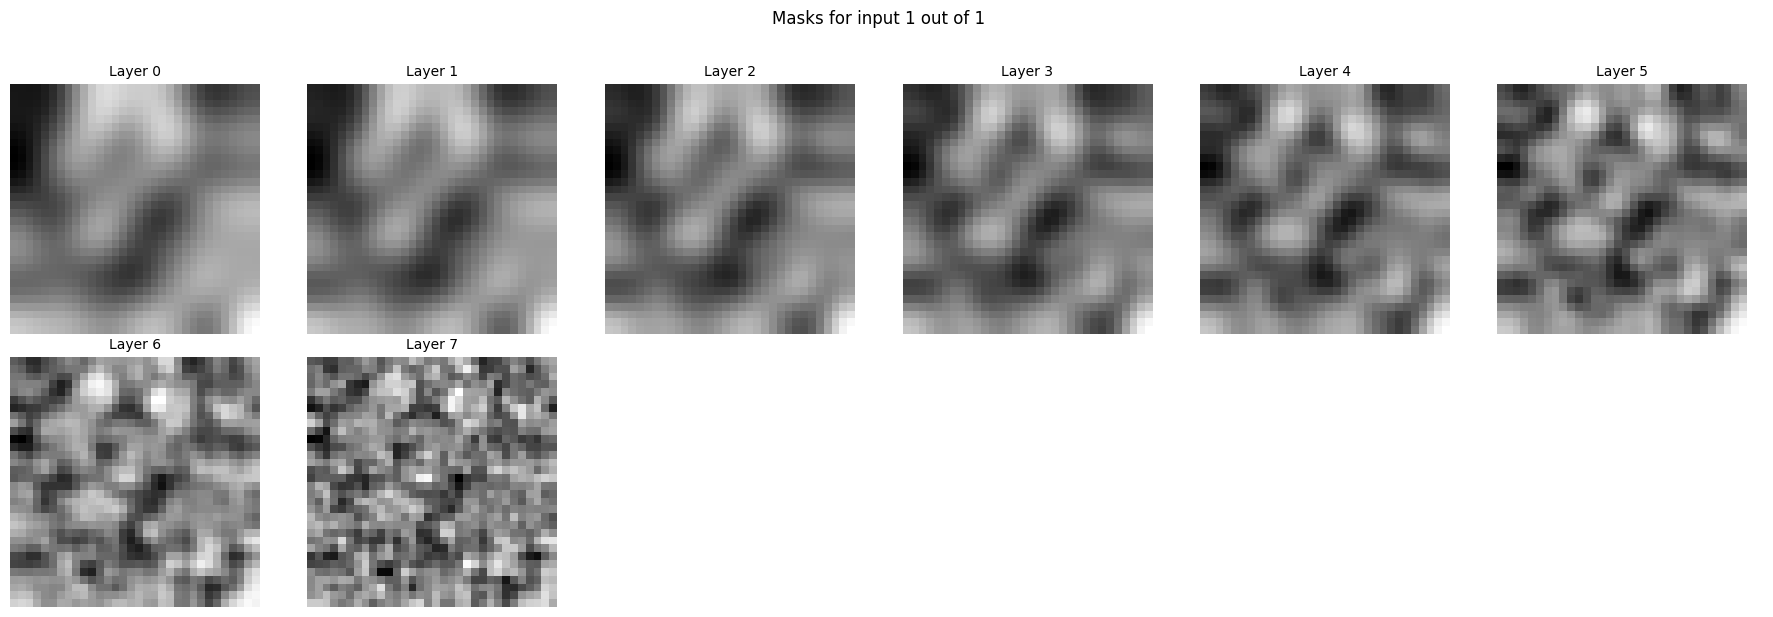


Visualizing image 2/2


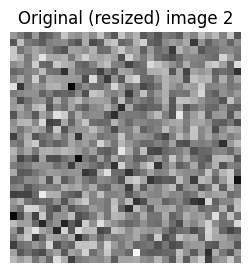

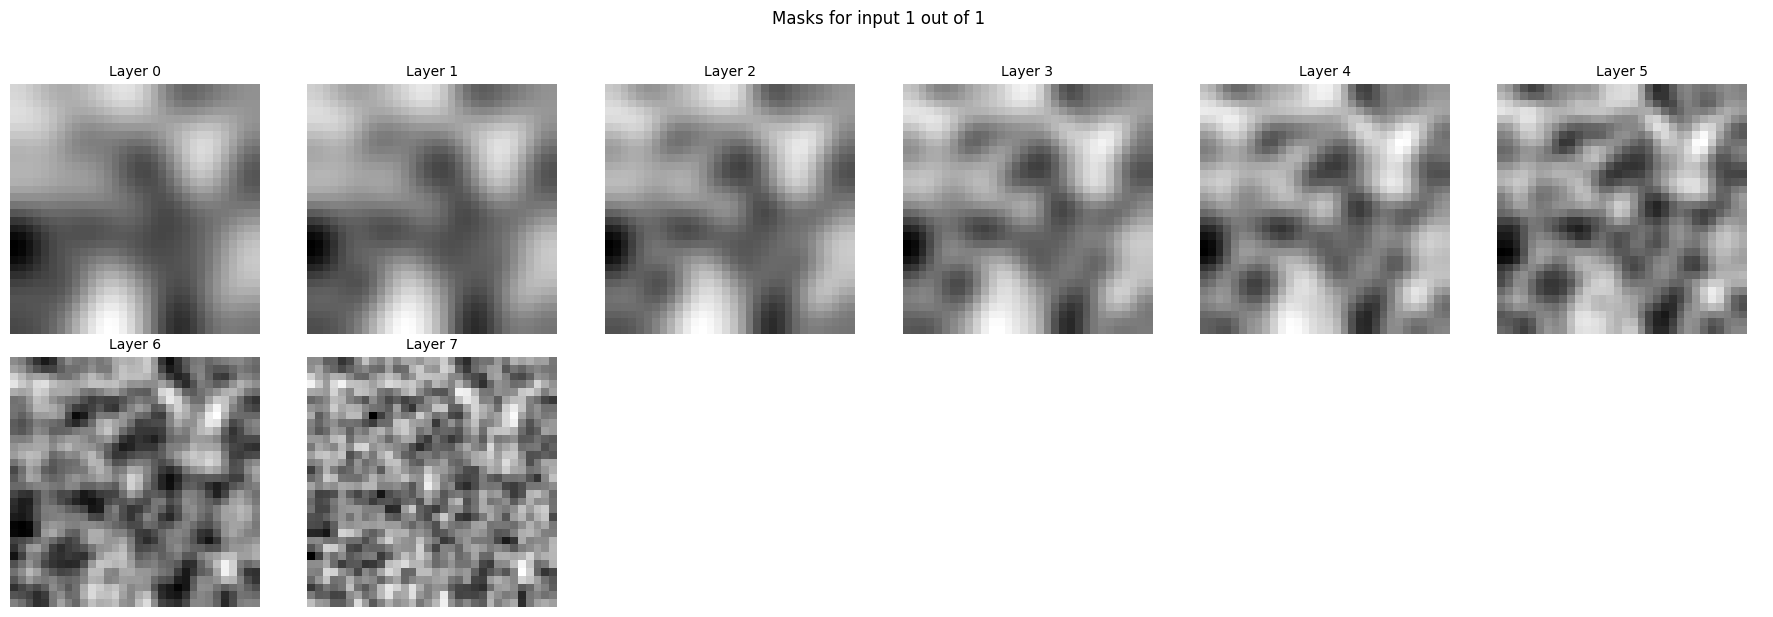

In [11]:
# Reproducible example: create a small batch of single-channel images (B, H, W)
torch.manual_seed(0)
random_tensor = torch.randn(2, 512, 512)  # Example tensor with shape (B, 512, 512)

# Generate gaussian multi-scale layers
stacked, flat, tiled = gaussian_layer_stack_pipeline(random_tensor, n_layers=8)

# Print shapes so you can see what each output contains
print('Stacked shape:', stacked.shape)    # expected (B, n_layers, 32, 32)
print('Flat shape:   ', flat.shape)       # expected (B, n_layers, 1024)
print('Tiled shape:  ', tiled.shape)      # expected (B, n_layers, 1024, 1024)

# Visualize the original (resized) input + the stacked layers for each image
num_images = random_tensor.shape[0]
for i in range(num_images):
    print(f'\nVisualizing image {i+1}/{num_images}')
    # Select the i-th image, shape (512, 512)
    random_tensor_i = random_tensor[i]
    # Input shape becomes (1, 1, 512, 512) for interpolation
    input_tensor = random_tensor_i.unsqueeze(0).unsqueeze(0)
    # Resize to (32, 32) for side-by-side comparison
    resized_tensor = torch.nn.functional.interpolate(input_tensor, size=(32, 32), mode='bilinear', align_corners=False)
    squeezed_tensor = resized_tensor.squeeze()  # (32, 32)
    normalized_tensor = (squeezed_tensor - squeezed_tensor.min()) / (squeezed_tensor.max() - squeezed_tensor.min())
    plot_data = normalized_tensor.detach().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(plot_data, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Original (resized) image {i+1}')
    plt.axis('off')
    plt.show()

    # stacked[i] has shape (n_layers, 32, 32); wrap it as batch (1, n_layers, 32, 32) for plotting helper
    _ = plot_layers_any(stacked[i].unsqueeze(0))

In [12]:
# Quick programmatic checks and a small example using the 'tiled' masks
# Inspect the first image, first layer
b, n_layers, h32, w32 = stacked.shape
assert h32 == 32 and w32 == 32, 'stacked should be (B, n_layers, 32, 32)'
print('n_layers =', n_layers)

# Show a numeric summary of the first tiled mask for the first image
first_tiled = tiled[0, 0]  # shape (1024, 1024)
print('First tiled mask shape:', first_tiled.shape)
print('min, max, mean:', float(first_tiled.min()), float(first_tiled.max()), float(first_tiled.mean()))

# If you need to use a tiled mask as an attention mask, you can downsample or crop it to the attention map size.
# Example: downsample tiled to 64x64 using simple averaging (toy example) -- avoid in production; adapt to your attention dims.
downsampled = torch.nn.functional.adaptive_avg_pool2d(first_tiled.unsqueeze(0).unsqueeze(0), (64,64)).squeeze()
print('Downsampled mask shape (toy):', downsampled.shape)

# Done. Try calling gaussian_layer_stack_pipeline with your real masks/images next.

n_layers = 8
First tiled mask shape: torch.Size([1024, 1024])
min, max, mean: 0.0 1.0 0.4977951645851135
Downsampled mask shape (toy): torch.Size([64, 64])


## Try it
- Replace the random tensor with a real single-channel mask or grayscale image batch (shape `(B, H, W)`) and re-run the cells.
- Use the `tiled` masks to elementwise-mask large attention maps (reshape or downsample as needed to match attention spatial dims).

## Notes
- The helpers are convenience utilities: when integrating into a model pipeline, ensure dtype and device (CPU/GPU) match your model (use `.to(device)` as needed).
- If you plan to generate masks for very large attention maps, avoid keeping huge (1024x1024) tensors in memory for many images at once; compute or stream them as needed.